In [47]:
import xgboost
import numpy as np
import shap
import time
from tqdm import tqdm
import matplotlib.pylab as pl

In [21]:
from iml.common import convert_to_instance, convert_to_model, match_instance_to_data, match_model_to_data, convert_to_instance_with_index
from iml.explanations import AdditiveExplanation
from iml.links import convert_to_link, IdentityLink
from iml.datatypes import convert_to_data, DenseData
import logging
from iml.explanations import AdditiveExplanation

log = logging.getLogger('shap')
from shap import KernelExplainer
class IMEExplainer(KernelExplainer):
    """ This is an implementation of the IME explanation method (aka. Shapley sampling values)
    
    This is implemented here for comparision and evaluation purposes, the KernelExplainer is
    typically more efficient and so is the preferred model agnostic estimation method in this package.
    IME was proposed in "An Efficient Explanation of Individual Classifications using Game Theory",
    Erik Štrumbelj, Igor Kononenko, JMLR 2010
    """
    
    def __init__(self, model, data, **kwargs):
        # silence warning about large datasets
        level = log.level
        log.setLevel(logging.ERROR)
        super(IMEExplainer, self).__init__(model, data, **kwargs)
        log.setLevel(level)
    
    def explain(self, incoming_instance, **kwargs):
        # convert incoming input to a standardized iml object
        instance = convert_to_instance(incoming_instance)
        match_instance_to_data(instance, self.data)
        
        # pick a reasonable number of samples if the user didn't specify how many they wanted
        self.nsamples = kwargs.get("nsamples", 0)
        if self.nsamples == 0:
            self.nsamples = 1000 * self.P
        
        # divide up the samples among the features
        self.nsamples_each = np.ones(self.P, dtype=np.int64) * 2 * (self.nsamples // (self.P * 2))
        for i in range((self.nsamples % (self.P * 2)) // 2):
            self.nsamples_each[i] += 2
        
        model_out = self.model.f(instance.x)
        
        # explain every feature
        phi = np.zeros(self.P)
        self.X_masked = np.zeros((self.nsamples_each.max(), X.shape[1]))
        for i in range(self.P):
            phi[i] = self.ime(i, self.model.f, instance.x, self.data.data, nsamples=self.nsamples_each[i])
        phi = np.array(phi)
        
        return AdditiveExplanation(self.link.f(1), self.link.f(1), phi, np.zeros(len(phi)), instance, self.link,
                                   self.model, self.data)
        
        
    def ime(self, j, f, x, X, nsamples=10):
        assert nsamples % 2 == 0, "nsamples must be divisible by 2!"
        X_masked = self.X_masked[:nsamples,:]
        inds = np.arange(X.shape[1])

        for i in range(0, nsamples//2):
            np.random.shuffle(inds)
            pos = np.where(inds == j)[0][0]
            rind = np.random.randint(X.shape[0])
            X_masked[i,:] = x
            X_masked[i,inds[pos+1:]] = X[rind,inds[pos+1:]]
            X_masked[-(i+1),:] = x
            X_masked[-(i+1),inds[pos:]] = X[rind,inds[pos:]]
        
        s = time.time()
        evals = f(X_masked)
        #print("n",time.time() - s)
        
        evals_on = evals[:nsamples//2]
        evals_off = evals[nsamples//2:][::-1]
        
        return np.mean(evals[:nsamples//2] - evals[nsamples//2:])

In [91]:
tree_shap_times = []
sample_times = []
Ms = [20,30,40,50,60,70,80,90,100]
for M in tqdm(Ms):
    
    X = np.random.randn(N, M)
    y = np.random.randn(N)
    model = xgboost.train({"eta": 1}, xgboost.DMatrix(X, y), 1000)
    
    #print()
    e = shap.TreeExplainer(model)
    s = time.time()
    e.shap_values(X)
    tree_shap_times.append((time.time() - s)/1000)
    #print((time.time() - s)/1000)
    
    tmp = np.vstack([X for i in range(1 * M)])
    s = time.time()
    model.predict(xgboost.DMatrix(tmp))
    sample_times.append(time.time() - s)

100%|██████████| 9/9 [00:26<00:00,  3.55s/it]


In [88]:
np.array(tree_shap_times)*10000

array([5.633111  , 5.85872889, 5.49962997, 5.51635981, 5.31605005,
       5.07364988, 4.98589039, 4.95893955, 4.9760294 , 4.86562967,
       4.64447975])

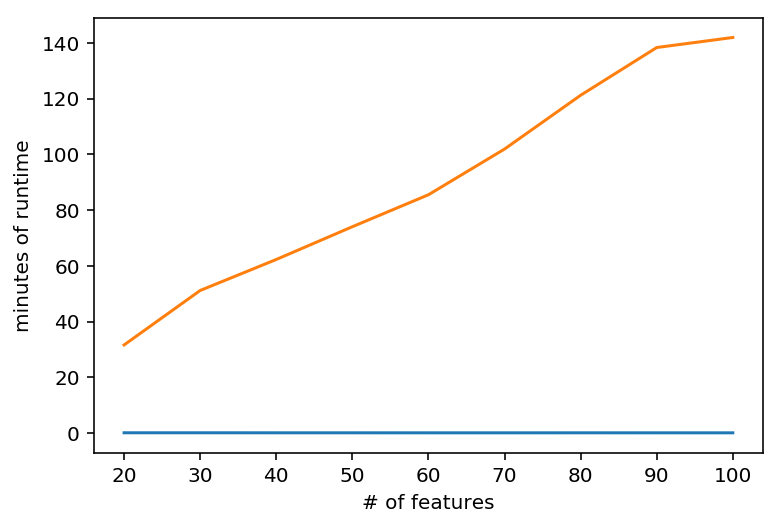

In [92]:
pl.plot(Ms, np.array(tree_shap_times[:-1])*10000 / (60))
pl.plot(Ms, np.array(sample_times[:-1])*10000 / (60))
pl.ylabel("minutes of runtime")
pl.xlabel("# of features")
pl.show()

In [162]:
np.mean(np.array(tree_shap_times[:-1])*10000)

5.271293222904205

In [165]:
4995.5940246/5.27129322

947.6979966976681

In [165]:
4995.5940246/5.27129322

947.6979966976681

In [170]:
sample_times[-5]/tree_shap_times[-5]

1016.5784222579987

In [164]:
np.mean(np.array(sample_times[:-1])*10000)

4995.594024658203

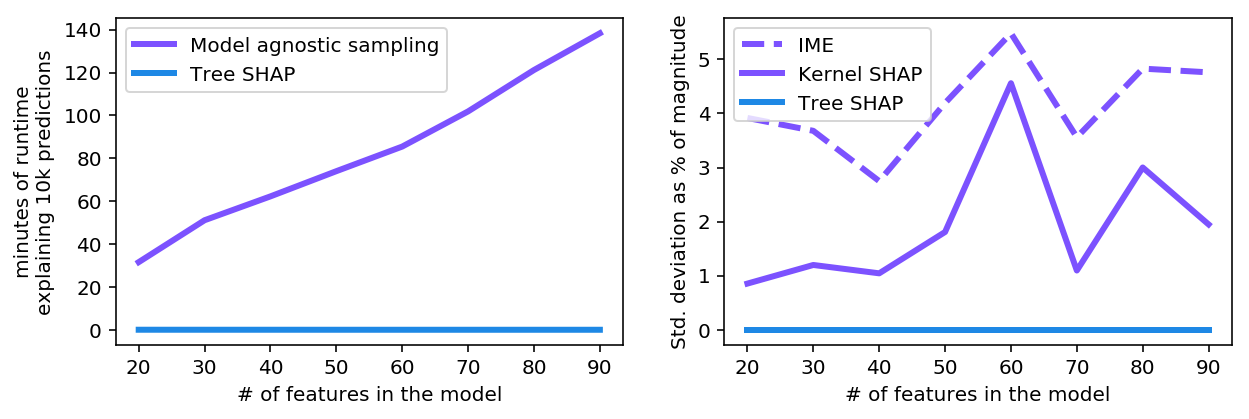

In [163]:
f = pl.figure(figsize=(10,3))
pl.subplot(1, 2, 1)
pl.plot(
    Ms[:-1], np.array(sample_times[:-1])*10000 / (60),
    label="Model agnostic sampling",
    color="#7C52FF", linewidth=3
)
pl.plot(
    Ms[:-1], np.array(tree_shap_times[:-1])*10000 / (60),
    label="Tree SHAP", color="#1E88E5", linewidth=3
)
pl.ylabel("minutes of runtime\nexplaining 10k predictions")
pl.xlabel("# of features in the model")
pl.legend()
#pl.savefig("runtime.pdf")
#pl.show()

pl.subplot(1, 2, 2)
pl.plot(
    Ms[:-1], (ime_std[:-1] / ime_m[:-1])*100, "--",
    label="IME", color="#7C52FF", linewidth=3
)
pl.plot(
    Ms[:-1], (kernel_shap_std[:-1] / kernel_shap_m[:-1])*100,
    label="Kernel SHAP",
    color="#7C52FF", linewidth=3
)
pl.plot(
    Ms[:-1], np.zeros(len(Ms)-1),
    label="Tree SHAP",
    color="#1E88E5", linewidth=3
)
pl.ylabel("Std. deviation as % of magnitude")
pl.xlabel("# of features in the model")
pl.legend(loc="upper left")
pl.savefig("perf.pdf")
pl.show()

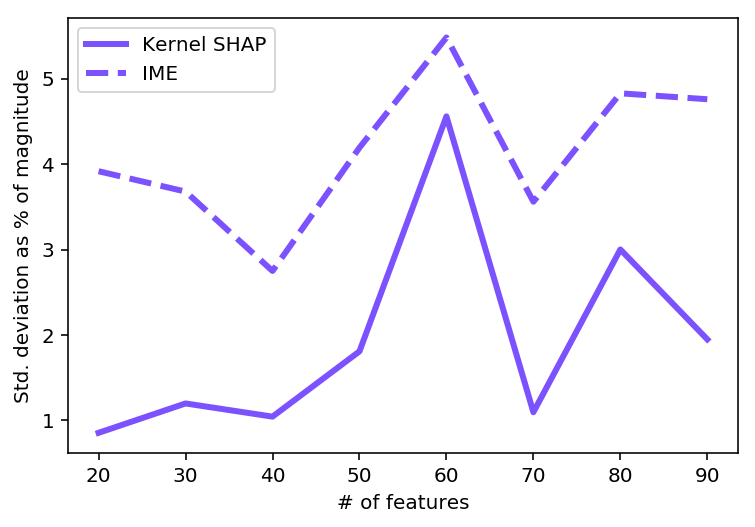

In [146]:
pl.plot(
    Ms[:-1], (kernel_shap_std[:-1] / kernel_shap_m[:-1])*100,
    label="Kernel SHAP",
    color="#7C52FF", linewidth=3
)
pl.plot(
    Ms[:-1], (ime_std[:-1] / ime_m[:-1])*100, "--",
    label="IME", color="#7C52FF", linewidth=3
)
pl.ylabel("Std. deviation as % of magnitude")
pl.xlabel("# of features")
pl.legend(loc="upper left")
#pl.savefig("std_dev.pdf")
pl.show()

In [98]:
np.mean(kernel_shap_std[:-1] / kernel_shap_m)

0.017660769984570657

In [105]:
np.mean(kernel_shap_std[:-1] / kernel_shap_m[:-1])

0.019387321525750678

In [106]:
np.mean(ime_std[:-1] / ime_m[:-1])

0.041465549361301236

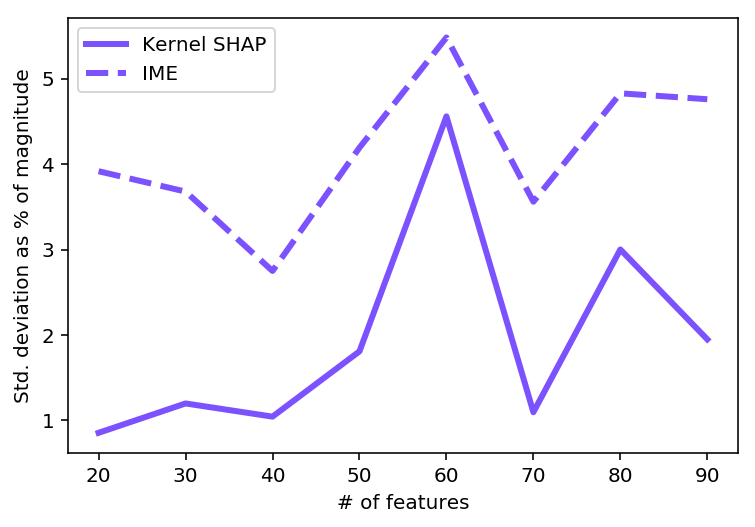

In [146]:
pl.plot(
    Ms[:-1], (ime_std[:-1] / ime_m[:-1])*100,
    label="IME", color="#7C52FF", linewidth=3
)
pl.plot(
    Ms[:-1], (kernel_shap_std[:-1] / kernel_shap_m[:-1])*100,
    label="Kernel SHAP",
    color="#7C52FF", linewidth=3
)
pl.plot(
    Ms[:-1], (ime_std[:-1] / ime_m[:-1])*100, "--",
    label="IME", color="#7C52FF", linewidth=3
)
pl.ylabel("Std. deviation as % of magnitude")
pl.xlabel("# of features")
pl.legend(loc="upper left")
#pl.savefig("std_dev.pdf")
pl.show()

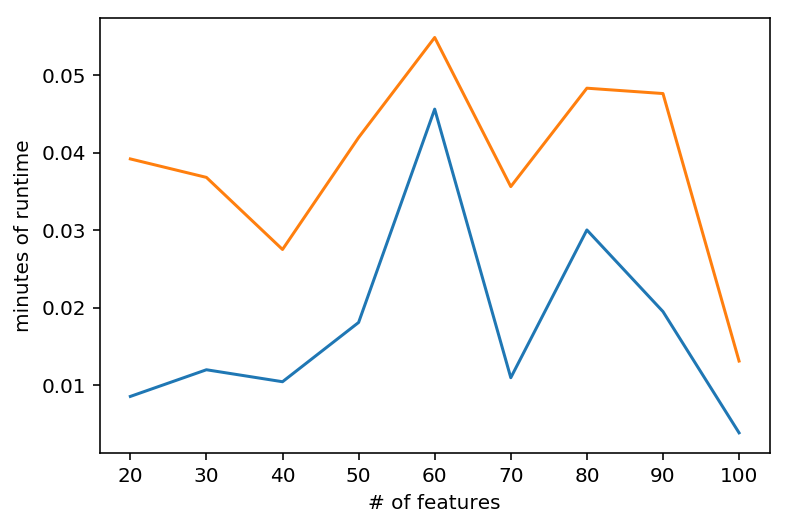

In [97]:
pl.plot(Ms, kernel_shap_std / kernel_shap_m)
pl.plot(Ms, ime_std / ime_m)
pl.ylabel("minutes of runtime")
pl.xlabel("# of features")
pl.plot()
pl.show()

In [104]:
np.array(sample_times) / np.array(tree_shap_times)

array([ 320.80395406,  552.44233763,  684.03119462,  841.14715592,
       1016.57842226, 1226.48211761, 1450.68094181, 1690.75300588,
       1728.4646152 ])

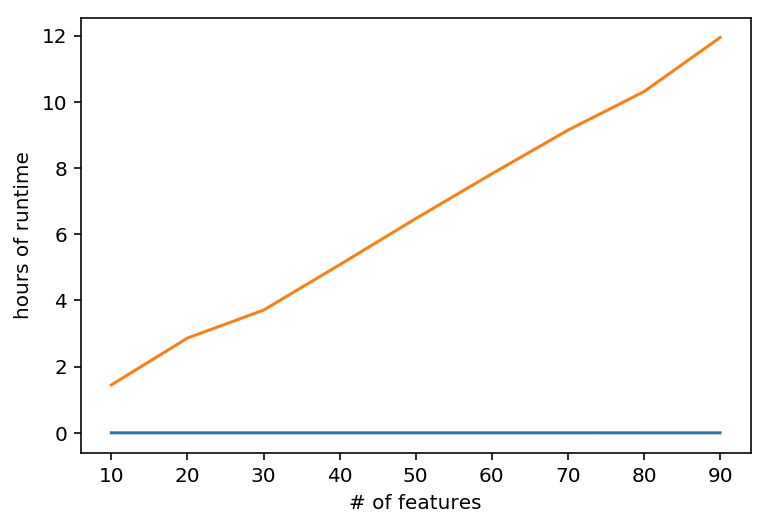

In [61]:
pl.plot(Ms, np.array(tree_shap_times)*10000 / (60*60))
pl.plot(Ms, np.array(sample_times)*10000 / (60*60))
pl.ylabel("hours of runtime")
pl.xlabel("# of features")
pl.show()

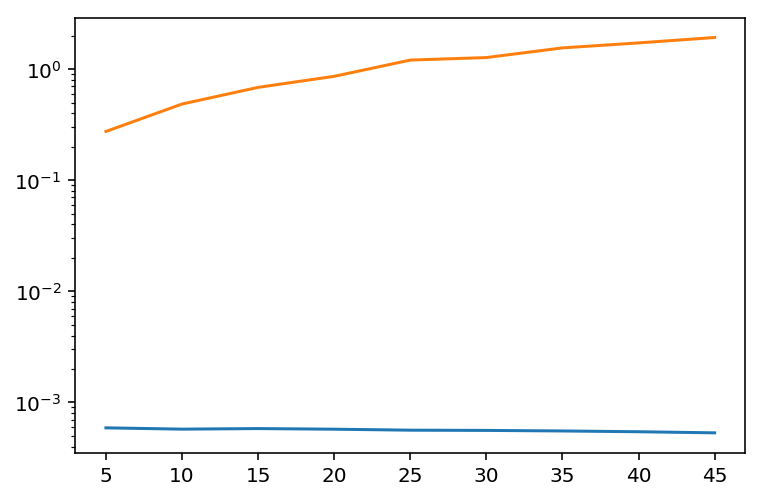

In [50]:
pl.semilogy(Ms, tree_shap_times)
pl.semilogy(Ms, sample_times)
pl.show()

In [42]:
2.1067/0.00056

3761.9642857142862

In [29]:
s = time.time()
model.predict(xgboost.DMatrix(X[:100,:]))
time.time() - s

0.0020101070404052734

In [ ]:
N = 1000
X_full = np.random.randn(N, 100)
y = np.random.randn(N)

tree_shap_times = []
kernel_shap_times = []
ime_times = []
tree_shap_std = []
kernel_shap_std = []
kernel_shap_m = []
ime_std = []
ime_m = []
for M in [20,30,40,50,60,70,80,90,100]:#,30,40,50]:
    print("\nM", M)
    X = X_full[:,:M]
    
    model = xgboost.train({"eta": 1}, xgboost.DMatrix(X, y), 1000)

    def f(x):
        return model.predict(xgboost.DMatrix(x))
    
    e = shap.TreeExplainer(model)
    start = time.time()
    e.shap_values(X)
    iter_time = (time.time() - start)/X.shape[0]
    tree_shap_times.append(iter_time)
    tree_shap_std.append(0)
    
    e = shap.KernelExplainer(f, X.mean(0).reshape(1,M))
    nsamples = 1000 * M
    start = time.time()
    out = np.vstack([e.shap_values(X[:1,:], silent=True, nsamples=nsamples) for i in range(50)])
    std_dev = out.std(0)[:-1].mean()
    mval = np.abs(out.mean(0))[:-1].mean()
    kernel_shap_m.append(mval)
    iter_time = (time.time() - start)/50
    kernel_shap_times.append(iter_time)
    kernel_shap_std.append(std_dev)
    print(std_dev, mval, std_dev / mval)
    print("KernelExplainer", iter_time)
    
    e = IMEExplainer(f, X.mean(0).reshape(1,M))
    nsamples = 1000 * M
    start = time.time()
    out = np.vstack([e.shap_values(X[:1,:], silent=True, nsamples=nsamples) for i in range(50)])
    std_dev = out.std(0)[:-1].mean()
    mval = np.abs(out.mean(0))[:-1].mean()
    ime_m.append(mval)
    iter_time = (time.time() - start)/50
    ime_times.append(iter_time)
    ime_std.append(std_dev)
    print(std_dev, mval, std_dev / mval)
    print("IMEExplainer", iter_time)

ime_std = np.array(ime_std)
ime_m = np.array(ime_m)
kernel_shap_std = np.array(kernel_shap_std)
kernel_shap_m = np.array(kernel_shap_m)


M 20
0.0007393969481046989 0.08655239076881058 0.008542767467621969
KernelExplainer 1.5829526567459107
0.0034187560235558454 0.08727476235122503 0.03917233265898269
IMEExplainer 0.40989099979400634

M 30
0.0012877561556381184 0.10746270935466279 0.0119832839072398
KernelExplainer 2.7619515800476075
0.003955039524908129 0.10750344677696065 0.03678988575234914
IMEExplainer 0.6094264173507691

M 40


In [95]:
ime_std

array([0.00341876, 0.00395504, 0.00228658, 0.00303863, 0.00220854,
       0.0014588 , 0.00276436, 0.00156815, 0.00030343])

In [100]:
ime_m

array([0.08727476, 0.10750345, 0.08316281, 0.07246471, 0.04027761,
       0.04097318, 0.05724012, 0.03294186, 0.02315394])

In [101]:
kernel_shap_std

array([7.39396948e-04, 1.28775616e-03, 8.63459855e-04, 1.29795187e-03,
       1.82790054e-03, 4.39236264e-04, 1.71100994e-03, 6.29363519e-04,
       8.80791006e-05])

In [102]:
kernel_shap_m

array([0.08655239, 0.10746271, 0.08271485, 0.07177752, 0.04009051,
       0.04008376, 0.05701191, 0.03229693, 0.02288745])

In [94]:
from tqdm import tqdm

tree_shap_times = []
kernel_shap_times = []
ime_times = []
nreps = 10

N = 1000
X_full = np.random.randn(N, 20)
y = np.random.randn(N)

for M in range(4,8):
    ts = []
    tree_shap_time = 0
    kernel_shap_time = 0
    ime_time = 0
    for k in tqdm(range(nreps)):
#         print()
         #+ ((X > 0).sum(1) % 2)
        X = X_full[:,:M]

        model = xgboost.train({"eta": 1}, xgboost.DMatrix(X, y), 1000)

        def f(x):
            return model.predict(xgboost.DMatrix(x))


        start = time.time()
        shap_values = shap.TreeExplainer(model).shap_values(X)
        tree_shap_time += time.time() - start
#         print("Tree SHAP:", tree_shap_time, "seconds")

        shap_stddev = shap_values.std(0)[:-1].mean()

#         print("mean std dev of SHAP values over samples:", shap_stddev)

        e = shap.KernelExplainer(f, X.mean(0).reshape(1,M))
        nsamples = 200
#         print(shap_stddev/20)
        for j in range(2000):
            #print(nsamples)
            start = time.time()
            std_dev = np.vstack([e.shap_values(X[:1,:], silent=True, nsamples=nsamples) for i in range(50)]).std(0)[:-1].mean()
            iter_time = (time.time() - start)/50
            #print(std_dev)
            if std_dev < shap_stddev/20:
#                 print("KernelExplainer", nsamples)
#                 print("KernelExplainer", std_dev)
#                 print("KernelExplainer", iter_time, "seconds")
                kernel_shap_time += iter_time * 1000
                break
            nsamples += int(nsamples * 0.5)

        e = IMEExplainer(f, X.mean(0).reshape(1,M))
        nsamples = 200
        for j in range(2000):
        #     print()
        #     print(nsamples)
            start = time.time()
            std_dev = np.vstack([e.shap_values(X[:1,:], silent=True, nsamples=nsamples) for i in range(50)]).std(0)[:-1].mean()
        #     print("time", (time.time() - start)/50)
        #     print(std_dev)
            iter_time = (time.time() - start)/50
            if std_dev < shap_stddev/20:
#                 print("IMEExplainer", nsamples)
#                 print("IMEExplainer", std_dev)
#                 print("IMEExplainer", iter_time, "seconds")
                ime_time += iter_time * 1000
                break
            nsamples += int(nsamples * 0.5)

    tree_shap_times.append(tree_shap_time / nreps)
    kernel_shap_times.append(kernel_shap_time / nreps)
    ime_times.append(ime_time / nreps)
    print("TreeExplainer", tree_shap_times[-1])
    print("KernelExplainer", kernel_shap_times[-1])
    print("IMEExplainer", ime_times[-1])


  0%|          | 0/10 [00:00<?, ?it/s]

TreeExplainer 0.5667633771896362
KernelExplainer 1.6998610496520996
IMEExplainer 36.06944036483765


  0%|          | 0/10 [00:00<?, ?it/s]

TreeExplainer 0.5962720394134522
KernelExplainer 2.410202980041504
IMEExplainer 24.168269634246826


  0%|          | 0/10 [00:00<?, ?it/s]

TreeExplainer 0.5785245656967163
KernelExplainer 3.6281538009643555
IMEExplainer 170.16926431655884


100%|██████████| 10/10 [06:38<00:00, 41.04s/it]

TreeExplainer 0.5870000839233398
KernelExplainer 5.659902095794678
IMEExplainer 254.79452514648438


In [96]:
model.predict(xgboost.DMatrix(X)).mean()

-0.035476692

In [97]:
shap.TreeExplainer(model).shap_values(X)

array([[ 0.35859036,  0.02820558, -0.0797407 , ...,  0.257011  ,
         0.14601958, -0.03547668],
       [-0.13089252,  0.05794828, -0.25855556, ...,  0.13599055,
         0.05735664, -0.03547668],
       [-0.06776153,  0.10805923, -0.15713027, ..., -0.03505304,
        -0.126518  , -0.03547668],
       ...,
       [ 0.2136814 ,  0.26080823, -0.28865245, ...,  0.37536186,
         0.0192902 , -0.03547668],
       [-0.26988652, -0.4866938 ,  0.08402091, ..., -0.9819344 ,
         0.10559861, -0.03547668],
       [ 0.2289274 ,  0.34278524,  0.04976799, ...,  0.17089835,
        -0.2589223 , -0.03547668]], dtype=float32)

In [68]:
e = shap.KernelExplainer(f, X.mean(0).reshape(1,M))
np.vstack([e.shap_values(X[:1,:], silent=True, nsamples=100) for i in range(50)]).std(0)[:-1].mean()

0.03536954622922005

In [72]:
e = shap.KernelExplainer(f, X.mean(0).reshape(1,M))
nsamples = 200
print(shap_stddev/20)
for j in range(2000):
    print(nsamples)
    start = time.time()
    std_dev = np.vstack([e.shap_values(X[:1,:], silent=True, nsamples=nsamples) for i in range(50)]).std(0)[:-1].mean()
    iter_time = time.time() - start)/50
    print(std_dev)
    if std_dev < shap_stddev/20:
        print(nsamples)
        break
    nsamples += int(nsamples * 0.2)

0.01028014048933983
200
time 0.017876300811767578
0.030893178278808088
240
time 0.01951019763946533
0.031826491957925064
288
time 0.020209121704101562
0.02404333546749491
345
time 0.026800222396850586
0.02191601539734573
414
time 0.03098787784576416
0.019460386139078127
496
time 0.035751018524169925
0.016387066172673846
595
time 0.04151914119720459
0.014285933327475487
714
time 0.04223478317260742
0.007730075891320169
714


In [74]:
e = IMEExplainer(f, X.mean(0).reshape(1,M))
nsamples = 200
print(shap_stddev/20)
for j in range(2000):
    print()
    print(nsamples)
    start = time.time()
    std_dev = np.vstack([e.shap_values(X[:1,:], silent=True, nsamples=nsamples) for i in range(50)]).std(0)[:-1].mean()
    print("time", (time.time() - start)/50)
    print(std_dev)
    if std_dev < shap_stddev/20:
        print(nsamples)
        break
    nsamples += int(nsamples * 0.2)

0.01028014048933983
200
time 0.00873462200164795
0.11283049739292224
240
time 0.008001022338867188
0.11367197853719405
288
time 0.011501140594482422
0.1015653587243526
345
time 0.009341177940368652
0.09609185923926047
414
time 0.011126718521118163
0.09085558541161791
496
time 0.013986682891845703
0.07316596561338537
595
time 0.015461082458496095
0.07250843647631118
714
time 0.01717233657836914
0.06397322007857624
856
time 0.022870540618896484
0.05976986733191383
1027
time 0.023901219367980956
0.05245597953754562
1232
time 0.027827000617980956
0.04745224231486926
1478
time 0.03509308338165283
0.044717441080350424
1773
time 0.03991847991943359
0.04005476391599552
2127
time 0.049641480445861814
0.03812949961499427
2552
time 0.055928120613098146
0.035810585105934746
3062
time 0.06629895687103271
0.03023017573129038
3674
time 0.08427309989929199
0.028151972927120038
4408
time 0.09465731620788574
0.0269187187096272
5289
time 0.11998224258422852
0.022239860334659148
6346
time 0.14299814224243

In [75]:
0.56939 * 1000

569.39

In [36]:
np.std([IMEExplainer(f, X.mean(0).reshape(1,M)).shap_values(X[:1,:], silent=True, nsamples=1000)[0,0] for i in range(10)])

0.10860389655048514

In [20]:
[shap.KernelExplainer(f, X.mean(0).reshape(1,M)).shap_values(X[:1,:], silent=True, nsamples=1000)[0,0] for i in range(100)]

[-0.023676379073087367,
 -0.016465743042426484,
 -0.01704981192550009,
 -0.018463699458183006,
 -0.015413553059016158,
 -0.018366587057752404,
 -0.018345955714953288,
 -0.01926604949186531,
 -0.020396613851721868,
 -0.022111201288591047,
 -0.021292876352076523,
 -0.016925113704097466,
 -0.02094528676946239,
 -0.017590427283719918,
 -0.019455733580809376,
 -0.01867957831829911,
 -0.01949199924313576,
 -0.02101184177451282,
 -0.02017175661418666,
 -0.02096841698600091,
 -0.018895762603090914,
 -0.019425187391885285,
 -0.018764209898906616,
 -0.02034981563789895,
 -0.016667910548829656,
 -0.019427677621697337,
 -0.019561391198267386,
 -0.02373383328585584,
 -0.017769291765458606,
 -0.014731135458020739,
 -0.01941898747203586,
 -0.020089057050320602,
 -0.019028685125618505,
 -0.01962223838514693,
 -0.014568940935971698,
 -0.01879752859462427,
 -0.018104240312813935,
 -0.019211399989558977,
 -0.021056719830586573,
 -0.018778172837663646,
 -0.017658694005700082,
 -0.019683240102995762,
 -0.0162219930410617,
 -0.019259564972963772,
 -0.01949005847120361,
 -0.020469469407407792,
 -0.012816015402021158,
 -0.017980626203507558,
 -0.020897377427076758,
 -0.01868522102558161,
 -0.019841164347362744,
 -0.01599499867003788,
 -0.023435164030154998,
 -0.021409903581716072,
 -0.021450264083101744,
 -0.019248117394281006,
 -0.019173267845621733,
 -0.021201344451321935,
 -0.013850440640304496,
 -0.021287986511504587,
 -0.017783326099606533,
 -0.019453412161091754,
 -0.01843054464371413,
 -0.017254967740485454,
 -0.019103215848530974,
 -0.01879518729784055,
 -0.016519074933045257,
 -0.020527604263832898,
 -0.014484539065507975,
 -0.019919451452777043,
 -0.01791397307200243,
 -0.014867680956663631,
 -0.018727430647644053,
 -0.018632469437516508,
 -0.018405491524922116,
 -0.01747364031491877,
 -0.01699568669949486,
 -0.01874634675402474,
 -0.01885201916934609,
 -0.02082471371013129,
 -0.018097378494376464,
 -0.020461013612397938,
 -0.01658913152329026,
 -0.021541127531476613,
 -0.021776620067082225,
 -0.020021620037416813,
 -0.01784317502978247,
 -0.02140662002036492,
 -0.02027189405855656,
 -0.021590607084915926,
 -0.018937654008019444,
 -0.01834817726407234,
 -0.01792343162344523,
 -0.02115901867004244,
 -0.019107028260820377,
 -0.02001855177068948,
 -0.019976099903129818,
 -0.013791710928271679,
 -0.021506799835474072,
 -0.01541739020484878]

In [7]:
def f(x):
    return model.predict(xgboost.DMatrix(x))

start = time.time()
shap_values2 = shap.KernelExplainer(f, X.mean(0).reshape(1,M)).shap_values(X)
print(time.time() - start)

  7%|▋         | 74/1000 [00:04<00:50, 18.27it/s]


KeyboardInterrupt: 

In [22]:
start = time.time()
IMEExplainer(f, X.mean(0).reshape(1,M)).shap_values(X)
print(time.time() - start)

  4%|▍         | 41/1000 [00:13<05:22,  2.97it/s]

KeyboardInterrupt: 